# Time Series Analysis with Recurrent Nueral Networks (Keras)

IPython Notebook Source Link: https://www.youtube.com/watch?v=A7Lj_5AIkWQ

1. Get and Clean data
2. Prepare Data
3. Split into Training and Testing Data
4. Assemble Model
5. Train Model
6. Evaluate Model
7. Profit?

In [17]:
# prevent unnecessary display of IPython warnings
import warnings
warnings.filterwarnings('ignore')

# Import Tensorflow to use GPU when implementing Neural Networks
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [18]:
# display available devices for Tensorflow to use
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7391525191321334936
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2673860721737199607
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1"
]


## 1. Get and Clean Data

In [19]:
# import necessary libraries and functions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import math

# Read in the historical data as a DataFrame
df = pd.read_csv('../Data Wrangling/DIA.csv')
df = df.dropna(how='any')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1998-01-20,77.812500,78.843750,77.406250,78.812500,48.168903,1744600
1,1998-01-21,78.093750,78.375000,77.281250,77.843750,47.576797,1839600
2,1998-01-22,77.187500,77.859375,76.937500,77.187500,47.175697,1662600
3,1998-01-23,77.500000,77.750000,76.312500,77.000000,47.061108,1693700
4,1998-01-26,77.375000,77.671875,76.937500,77.312500,47.252090,1172800
...,...,...,...,...,...,...,...
5682,2020-08-18,279.100006,279.369995,277.109985,278.200012,277.595306,1678300
5683,2020-08-19,278.679993,279.739990,276.970001,277.429993,276.826965,3374300
5684,2020-08-20,276.040009,278.339996,275.869995,277.869995,277.265991,2063700
5685,2020-08-21,277.040009,279.609985,276.859985,279.290009,279.290009,2601200


## 2. Prepare Data

In [20]:
# Calculate Adj High and Adj Low by an adjustment factor 
df['Adj High'] = (df['Adj Close']/df['Close'])*df['High']
df['Adj Low'] = (df['Adj Close']/df['Close'])*df['Low']

# Define new "data" DataFrame to for the next step below
data=df[['Adj Close','Adj High','Adj Low']]

# Define Daily and Weekly return and High-Low range to prepare for reframing
data['dailyReturn'] = np.log(data.loc[:,('Adj Close')]/data.loc[:,('Adj Close')].shift(1))
data['weeklyReturn'] = np.log(data.loc[:,'Adj Close']/data.loc[:,'Adj Close'].shift(5))
data['dailyHL'] = np.log(data.loc[:,'Adj High']/data['Adj Low'])
data['weeklyHL'] = np.log(data.loc[:,'Adj High'].rolling(6).max()/data.loc[:,'Adj Low'].rolling(6).min())

In [21]:
# Define toTimeSeries functions that creates trailing and leading columns based on a desired number of shifting periods.
# The resulting DataFrame will serve as observation data to be used by the RNN as training and testing data.
def toTimeSeries(df,columns,n_trail=1,n_lead=1):
    df = df[columns]
    n_columns=len(columns)
    cols=[]
    names=[]
    
    # Create trailing columns
    for i in range(n_trail,0,-1):
        cols.append(df.shift(i))
        names += [(columns[j]+'(t-%d)'%(i))  for j in range(n_columns)]
        
    # Create leading columns
    for i in range(0,n_lead+1):
        cols.append(df.shift(-i))
        names += [(columns[j]+'(t+%d)'%(i))  for j in range(n_columns)]
        
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    
    # Clean up NaN rows
    agg.dropna(inplace=True)
    
    return agg

In [22]:
n_trail = 5 # Define number of trailing periods
n_lead = 5 # Define number of leading periods
columns = ['dailyReturn','weeklyReturn','dailyHL','weeklyHL'] # Define columns to be reframed

# Generate reframed data
reframed = toTimeSeries(data,columns,n_trail,n_lead)
print(reframed.head())

    dailyReturn(t-5)  weeklyReturn(t-5)  dailyHL(t-5)  weeklyHL(t-5)  \
10          0.011655          -0.007562      0.019075       0.032632   
11          0.011518           0.016325      0.012901       0.037573   
12          0.003549           0.028340      0.017084       0.050310   
13         -0.002167           0.028605      0.012193       0.050310   
14          0.022232           0.046787      0.011208       0.055307   

    dailyReturn(t-4)  weeklyReturn(t-4)  dailyHL(t-4)  weeklyHL(t-4)  \
10          0.011518           0.016325      0.012901       0.037573   
11          0.003549           0.028340      0.017084       0.050310   
12         -0.002167           0.028605      0.012193       0.050310   
13          0.022232           0.046787      0.011208       0.055307   
14          0.007877           0.043009      0.012513       0.057890   

    dailyReturn(t-3)  weeklyReturn(t-3)  ...  dailyHL(t+3)  weeklyHL(t+3)  \
10          0.003549           0.028340  ...      0.00993

## 3. Split into Training and Testing Data

In [23]:
trainTestSplit = 0.75 # Define train-test split percentage

mask = np.random.rand(len(reframed.values)) < trainTestSplit

train = reframed.values[mask,:]
test = reframed.values[~mask,:]
print(train.shape)

# Number of features
n_columns = len(columns)
n_features = (n_lead - 1) * n_columns
n_periods = n_trail + 1

# Number of periods in observation
n_obs = n_periods * n_columns

# Assign input (X) and expected output (Y) training set
X_train, Y_train = train[:,0:n_obs], train[:,-n_features:]
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], n_periods, n_columns))

new_train = []
for i, train in enumerate(Y_train):
    new_train.append(Y_train[i][-n_columns:].tolist())
Y_train = np.array(new_train)

# Assign input (X) and expected output (Y) training set
X_test, Y_test = test[:,0:n_obs], test[:,-n_features:]
X_test = X_test.reshape((X_test.shape[0], n_periods, n_columns))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

new_test = []
for i, test in enumerate(Y_test):
    new_test.append(Y_test[i][-n_columns:].tolist())
Y_test = np.array(new_test)

# Dimensions of training and test sets
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(4319, 44)
(4319, 24)
(4319, 6, 4) (4319, 4) (1353, 6, 4) (1353, 16)
(4319, 6, 4) (4319, 4) (1353, 6, 4) (1353, 4)


## 4. Assemble the Model

In [24]:
# Import Keras (with Tensorflow already imported earlier as the backend) to assemble RNN layers
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Define desired simple RNN architecture to be used by an Nvidia GTX 1070 Ti GPU and compile
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1:])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(len(columns)))
    model.compile(loss='mae',optimizer='Adam')

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0


In [25]:
# Confirm compiled RNN architecture with desired properties and parameters
print(model.summary())
model.get_config()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 6, 50)             11000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 6, 50)             20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 204       
Total params: 51,604
Trainable params: 51,604
Non-trainable params: 0
_________________________________________________________________
None


{'name': 'sequential_2',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm_4',
    'trainable': True,
    'batch_input_shape': (None, 6, 4),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,

## 5. Train the Model

Train on 4319 samples, validate on 1353 samples
Epoch 1/50
Executing op __inference_keras_scratch_graph_23920 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_24224 in device /job:localhost/replica:0/task:0/device:GPU:0
 - 3s - loss: 0.0131 - val_loss: 0.0126
Epoch 2/50
 - 1s - loss: 0.0122 - val_loss: 0.0117
Epoch 3/50
 - 1s - loss: 0.0116 - val_loss: 0.0111
Epoch 4/50
 - 1s - loss: 0.0114 - val_loss: 0.0113
Epoch 5/50
 - 1s - loss: 0.0116 - val_loss: 0.0106
Epoch 6/50
 - 1s - loss: 0.0112 - val_loss: 0.0104
Epoch 7/50
 - 1s - loss: 0.0110 - val_loss: 0.0103
Epoch 8/50
 - 1s - loss: 0.0109 - val_loss: 0.0103
Epoch 9/50
 - 1s - loss: 0.0108 - val_loss: 0.0103
Epoch 10/50
 - 1s - loss: 0.0107 - val_loss: 0.0103
Epoch 11/50
 - 1s - loss: 0.0107 - val_loss: 0.0102
Epoch 12/50
 - 1s - loss: 0.0107 - val_loss: 0.0101
Epoch 13/50
 - 1s - loss: 0.0106 - val_loss: 0.0100
Epoch 14/50
 - 1s - loss: 0.0106 - val_loss: 0.0100
Epoch 15/50
 - 1s - l

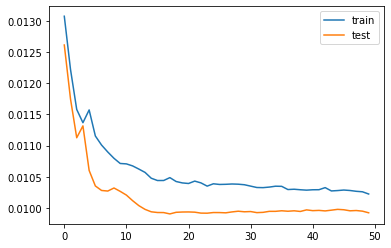

In [26]:
# fit simple RNN
history = model.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

# plot validation loss on training and test sets
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 6. Evaluate the Model

In [27]:
# Generate predictions from simple RNN model on input test data (X_test) and create 
# "results" DataFrame to store predictions and actuals (Y_test) for comparison
Y_predicted = model.predict(X_test)
results = pd.DataFrame(Y_test)
col1, col2, col3, col4 = [],[],[],[]

for pred in Y_predicted:
    col1.append(pred[0])
    col2.append(pred[1])
    col3.append(pred[2])
    col4.append(pred[3])

results[2], results[3], results[4], results[5] = col1, col2, col3, col4
results.columns = ['Daily Return','Weekly Return','Predicted Daily', 
                   'Predicted Weekly', 'Daily HL', 'Weekly HL']
results.head()

Executing op __inference_keras_scratch_graph_40312 in device /job:localhost/replica:0/task:0/device:GPU:0


,Daily Return,Weekly Return,Predicted Daily,Predicted Weekly,Daily HL,Weekly HL
0,0.000000,0.023576,0.001107,0.004783,0.009594,0.032787
1,0.006368,0.029752,0.001064,0.004894,0.010109,0.034680
2,0.006669,0.017508,0.001142,0.004056,0.008548,0.029722
3,-0.000370,0.007259,0.001071,0.004489,0.008036,0.028118
4,-0.008806,-0.004413,0.001299,0.003603,0.007062,0.025672


In [28]:
# Treat a signal's prediction as an upward (positive) or downward (negative) vector 
# and define accuracy scores based on two cases:
# i) direction and magnitude 
# ii) direction-only 

results['Correct'] = (results['Weekly Return']/results['Predicted Weekly']).apply(lambda x : 1 if x > 0.5 and x < 2 else 0)
results['Correct2'] = (results['Weekly Return']*results['Predicted Weekly']).apply(lambda x : 1 if x > 0 else 0)

print('Direction and Magnitude Accuracy Score: ', results.Correct.sum()/results.Correct.count())
print('Direction Only Accuracy Score: ', results.Correct2.sum()/results.Correct2.count())

Direction and Magnitude Accuracy Score:  0.1574279379157428
Direction Only Accuracy Score:  0.5934959349593496


## 7. Profit?

In [29]:
# Calculate Risk-Reward column based on which weeks are "confidently" 
# considered as Buying and Selling weeks as a rough, simple backtest
results['Risk-Reward'] = results['Predicted Weekly']/results['Weekly HL']
analyze = results.copy(deep=True)

# Define Buy/Sell thresholds
buySignal = analyze['Risk-Reward'].quantile(0.95)
sellSignal = analyze['Risk-Reward'].quantile(0.05)

# Calculate average annualized return over the entire investment period 
# with a starting investment of $1000 for both strategies
portfolio = [1000]
hodl = [1000]
bpFee = 20 # define portfolio management fees
feeModifier = 1 - (bpFee / 10000) # define fee modifier for portfolio calculations

predicted = results['Predicted Weekly'].tolist()
actual = results['Weekly Return'].tolist()
riskReward = results['Risk-Reward'].tolist()

# Decide the following for each prediction
for prediction in riskReward:
    idx = riskReward.index(prediction)
    if prediction > buySignal: # Calculate the result of a simulated long position 
                               # if a prediction is above the Buy threshold
        today = np.exp(actual[idx])*(portfolio[-1]*feeModifier)
    elif prediction < sellSignal: # Calculate the result of a simulated short position 
                               # if a prediction is below the Sell threshold
        today = np.exp(-actual[idx])*(portfolio[-1]*feeModifier)
    else:
        today = portfolio[-1] # Do nothing if the prediction does not surpass either threshold
    
    # Append result to portfolio list
    portfolio.append(today)
    
    # Calculate change in account value and append result to hodl list
    hodl.append(np.exp(actual[idx])*hodl[-1])
    
print('Annualized Return: ', ((((portfolio[-1]-1000)/1000)+1)**(52/len(portfolio))-1)*100,'%')

Annualized Return:  -0.06540175757792088 %


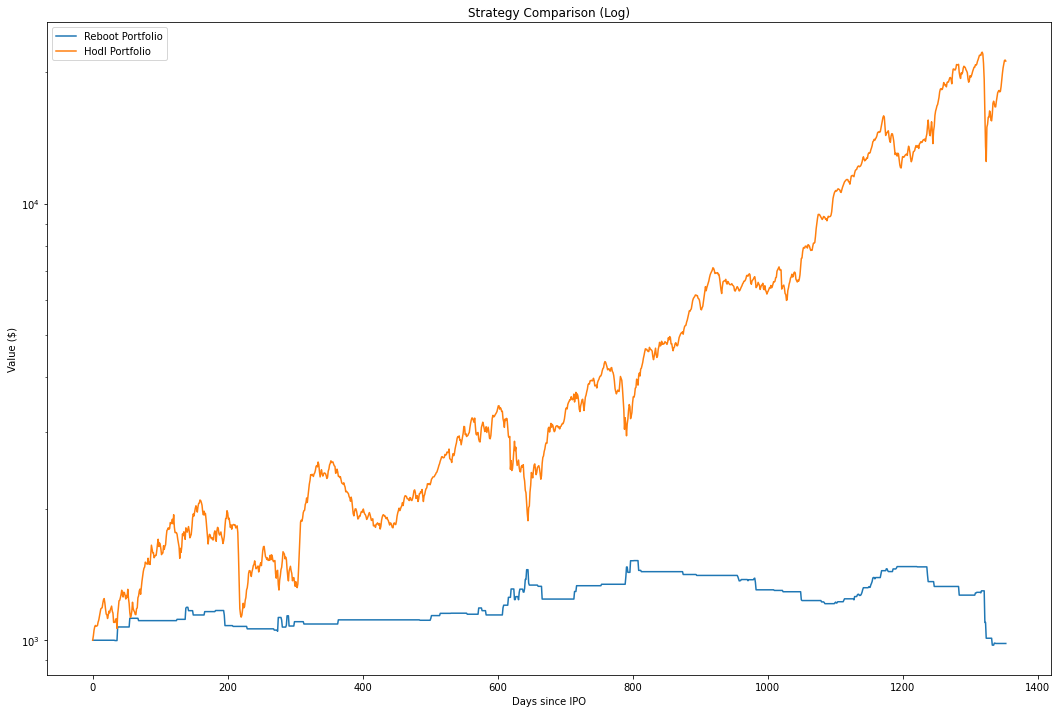

In [30]:
# Plot performance of both strategies over entire investment period for comparison along a LOG y-axis
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.legend()
plt.xlabel('Days since IPO')
plt.ylabel('Value ($)')
plt.title('Strategy Comparison (Log)')
plt.yscale('log')
plt.show()

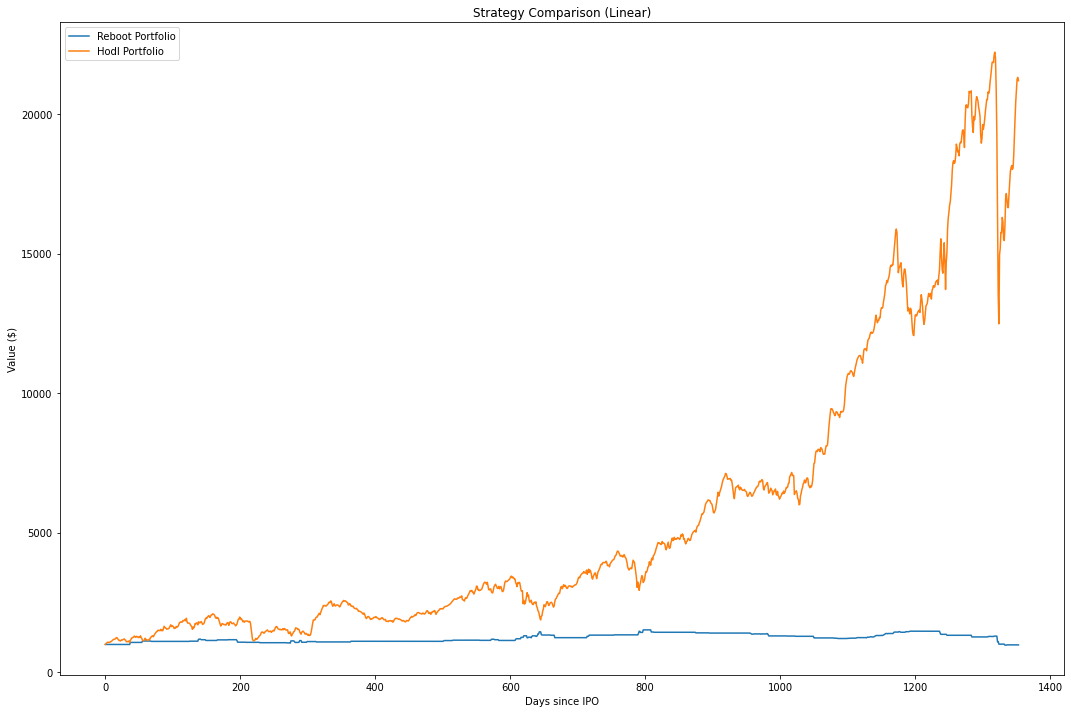

In [31]:
# Plot performance of both strategies over entire investment period for comparison along a LINEAR y-axis
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.xlabel('Days since IPO')
plt.ylabel('Value ($)')
plt.title('Strategy Comparison (Linear)')
plt.legend()
plt.show()

In [32]:
# Display results data to be used in Results Visuals notebook
port_df = pd.DataFrame(portfolio,index=time,columns=['portfolio'])
port_df['hodl'] = hodl
port_df['symbol'] = 'DIA'
port_df.head(10)

,portfolio,hodl,symbol
0,1000.0,1000.000000,DIA
1,1000.0,1023.855927,DIA
2,1000.0,1054.774865,DIA
3,1000.0,1073.404036,DIA
4,1000.0,1081.224638,DIA
5,1000.0,1076.463257,DIA
6,1000.0,1078.424504,DIA
7,1000.0,1079.991250,DIA
8,1000.0,1100.036062,DIA
9,1000.0,1112.483430,DIA
